#  Human Induced Earthquake Analysis - By Meenakshi Nadimuthu

In [286]:
# Import all the necessary libraries for the Project 

%matplotlib notebook
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import requests
import gmaps
import datetime
import numpy as np
from matplotlib import cm
import warnings
import seaborn as sns
# from ipywidgets.embed import embed_minimal_html
import regex
import scipy.stats as stats



### USGS recorded Earthquake for past day

In [287]:
# Retrieve the PastDay Earthquake feed details from USGS website

PastDayEarthquakefeedURL ="https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_day.geojson"

response = requests.get(PastDayEarthquakefeedURL).json()

featureslist= response["features"]

i = 0

# Data extraction from the JSON response 

PastDayEarthquakeDF = pd.DataFrame()
PastDayEarthquakeDF["Location"] = ""
PastDayEarthquakeDF["Latitude"] = ""
PastDayEarthquakeDF["Longitude"] = ""
PastDayEarthquakeDF["Magnitude"] = ""

for feeds in featureslist:
    place = feeds["properties"]["place"]
    lon = feeds["geometry"]["coordinates"][0]
    lat = feeds["geometry"]["coordinates"][1]
    mag = feeds["properties"]["mag"]
    
    PastDayEarthquakeDF.loc[i, "Location"] = place
    PastDayEarthquakeDF.loc[i, "Latitude"] = lat
    PastDayEarthquakeDF.loc[i, "Longitude"] = lon
    PastDayEarthquakeDF.loc[i, "Magnitude"] = mag    
    i+=1

PastDayEarthquakeDF.head(1000)

#Save the retrieved PastDayEarthquake data to a CSV file.

PastDayEarthquakeDF.to_csv("Output\PastDayEarthQuake.csv", index=False)


In [288]:
# Forming the Infobox content for each Marker. 

locations = PastDayEarthquakeDF[["Latitude", "Longitude"]].astype(float)
places = PastDayEarthquakeDF["Location"]
magnitude = PastDayEarthquakeDF["Magnitude"].astype(float)

EQInfo =[]

# Forming a list of strings with Location and Magnitude

for loc,mag in zip(places, magnitude):
     EQInfo.append(f"Location {loc} and  Magnitude: {mag}")



In [289]:
# Plot gmap Marker map
fig = gmaps.figure(map_type="HYBRID")

marker_layer = gmaps.marker_layer(locations, info_box_content=EQInfo)

fig.add_layer(marker_layer)

fig

# embed_minimal_html('PastDayEarthquake.html', views=[fig])

Figure(layout=FigureLayout(height='420px'))

### Human Induced earthquake Data Cleaning

In [290]:
HIEData = pd.read_csv("Resources\The_Human_Induced_Earthquake_Database - HiQuake.csv")


In [291]:
country = HIEData["Country"]
Maincause = HIEData["Earthquake cause (main class)"]
Subcause = HIEData["Earthquake cause (subclass)"]
Latitude = HIEData["Latitude (approximate)"]
Longitude  = HIEData["Longitude (approximate)"]
Magnitude = HIEData["Observed maximum magnitude (Mmax)"]
DateofOccurence = HIEData["Year of Mmax"].replace("NaN", 0)
Depth = HIEData["Depth of Mmax (m)"].replace("NaN", 0)

HIEData_formatted = pd.DataFrame({"Country":country, 
                                  "Main Cause" : Maincause,
                                  "Sub Cause" : Subcause, 
                                  "Latitude" :Latitude, 
                                  "Longitude" :Longitude, 
                                  "Magnitude": Magnitude,
                                  "DateofOccurence": DateofOccurence , 
                                  "Depth" : Depth
   
                                 })

clean_HIEData = HIEData_formatted.dropna(how="any")

clean_HIEData.head()

,Country,Main Cause,Sub Cause,Latitude,Longitude,Magnitude,DateofOccurence,Depth
2,Botswana,Coal Bed Methane (CBM),Coal Bed Methane (CBM),-22.586373,25.84591,6.3,2017.0,25200
3,UK,Construction,Coastal engineering (geoengineering),51.104297,1.271382,4.2,2007.0,500
4,Taiwan,Construction,Construction,25.033985,121.56442,3.8,2004.0,10000
6,Uzbekistan,Conventional Oil and Gas,Gas extraction and storage,40.216331,63.465234,7.3,1976.0,10000-20000
7,USA,Conventional Oil and Gas,Oil extraction and Secondary recovery (water i...,36.138932,-120.3809,6.5,1983.0,10000


####  Magnitude Vs Depth plotting
The strength of shaking from an earthquake diminishes with increasing distance from the earthquake's source, so the strength of shaking at the surface from an earthquake that occurs at 500km deep is considerably less than if the same earthquake had occurred at 20 km depth.



In [292]:
Indexedclean_HIEData = clean_HIEData.set_index("Country")

HIQuakes = Indexedclean_HIEData[["Magnitude", "Depth"]]

HIQuakes["Depth"] = HIQuakes["Depth"].apply(pd.to_numeric, errors='coerce')

HIQuakes = HIQuakes.dropna(how="any")


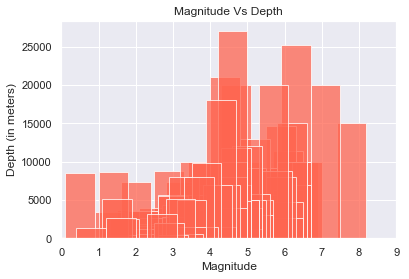

In [293]:
AllHIMags = HIQuakes["Magnitude"]
AllDepth =HIQuakes["Depth"]


plt.bar(AllHIMags, AllDepth, color="#FF6550" , alpha =0.75)
plt.ylabel("Depth (in meters)")
plt.xlabel("Magnitude")
plt.title ("Magnitude Vs Depth")
plt.xlim(0,9)
plt.grid()

plt.savefig("Images\Magnitude Vs Depth.png")
# plt.show()

### Classification of Human Induced EarthQuake for USA over the years

In [294]:
Indexedclean_HIEDataUpdated = Indexedclean_HIEData.loc["USA", ["Magnitude", "DateofOccurence"]]


xaxis = Indexedclean_HIEDataUpdated["Magnitude"]
yaxis = Indexedclean_HIEDataUpdated["DateofOccurence"].apply(pd.to_numeric, errors='coerce').unique()

zippedtuples = list(zip(xaxis,yaxis))
ZippedDF= pd.DataFrame(zippedtuples,  columns=['Magnitude','Years'])

ZippedDF.head()


,Magnitude,Years
0,6.5,1983.0
1,6.1,1985.0
2,5.9,1987.0
3,5.3,1978.0
4,4.9,1997.0


In [295]:
#Create bins to classify the Earthquake magnitudes

bins = [0, 2, 3, 4, 5, 6,7,8]
labels =["Very Minor","Minor", "Light", "Moderate", "Strong", "Major", "Great"]

ZippedDF["Magnitude Classification"] = pd.cut(ZippedDF["Magnitude"], bins=bins, labels=labels)



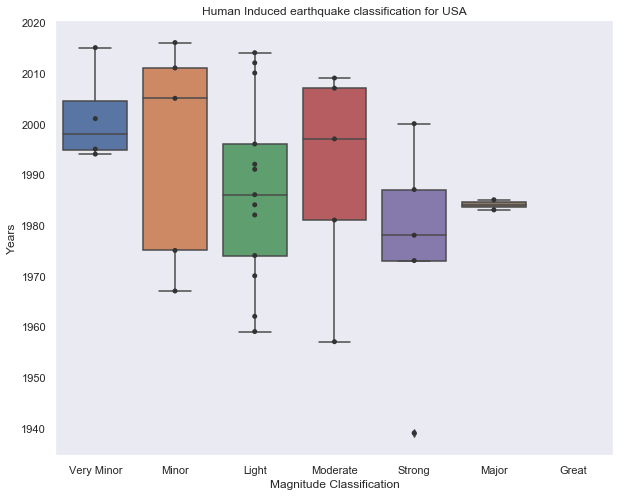

In [296]:
# Plot the classification using the Seaborn library

sns.set(style="dark")

a4_dims = (10, 8)
fig, ax = plt.subplots(figsize=a4_dims)

ax = sns.boxplot(ax=ax, x=ZippedDF["Magnitude Classification"] , y=ZippedDF["Years"])
ax = sns.swarmplot(ax=ax, x=ZippedDF["Magnitude Classification"] , y=ZippedDF["Years"], color=".2").set_title("Human Induced earthquake classification for USA")

fig.savefig("Images\Human Induced earthquake classification for USA.png")

### Hypothesis : 
The magnitudes of HIQuakes caused by Mining is significantly different from magnitudes of HIQuakes caused by Water Reservoir Impoundment

### Null Hypothesis: 
The magnitudes of HIQuakes caused by Mining is NOT significantly different from magnitudes of HIQuakes caused by Water Reservoir Impoundment

In [297]:
# Retrieve the Magnitudes for "Water reservoir impoundment" cause and "Mining" cause

WaterReserImpoundMags = clean_HIEData[clean_HIEData["Main Cause"]=="Water reservoir impoundment"]["Magnitude"]
MiningMags = clean_HIEData[clean_HIEData["Main Cause"]=="Mining"]["Magnitude"]

print(f"Mean of Water reservoir impoundment ={WaterReserImpoundMags.mean()}")
print(f"Mean of Mining ={MiningMags.mean()}")



Mean of Water reservoir impoundment =4.64186046511628
Mean of Mining =3.5537037037037034


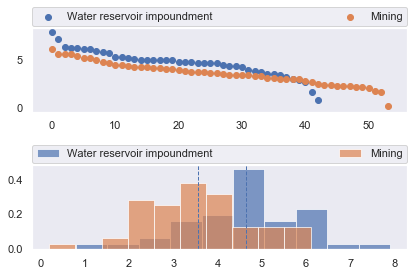

In [298]:
# Scatter Plot of Cause and Magnitude data

plt.subplot(2, 1, 1)
plt.scatter(range(len(WaterReserImpoundMags)), WaterReserImpoundMags, label="Water reservoir impoundment")
plt.scatter(range(len(MiningMags)), MiningMags, label="Mining")
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=2, mode="expand", borderaxespad=0.)

# Histogram Plot of Cause and Magnitude data
plt.subplot(2, 1, 2)
plt.hist(WaterReserImpoundMags, 10, density=True, alpha=0.7, label="Water reservoir impoundment")
plt.hist(MiningMags, 10, density=True, alpha=0.7, label="Mining")
plt.axvline(WaterReserImpoundMags.mean(), color='b', linestyle='dashed', linewidth=1)
plt.axvline(MiningMags.mean(), color='b', linestyle='dashed', linewidth=1)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',ncol=2, mode="expand", borderaxespad=0.) 
plt.tight_layout()
plt.savefig("Images\Statistics_Cause Vs Magnitude.png")
# plt.show()

In [299]:
# Execute a Independent t-test to verify the significance of the two dataset

stats.ttest_ind(WaterReserImpoundMags,MiningMags, equal_var=False)

Ttest_indResult(statistic=4.154549887965083, pvalue=7.793388460472081e-05)

####  Independent t-test result : A pvalue of 7.79e-05  is compartively very smaller to the alpha (0.05),so we are rejecting the Null Hypothesis. 
The magnitudes of HIQuakes caused by Mining is significantly different from magnitudes of HIQuakes caused by Water Reservoir Impoundment. 